# [E-03] Sticker

> 목차
-



1. 개요  
2. 루브릭 평가기준  
3. 기본 Project  
4. 응용 Project  
5. 회고  
6. 참조

---

> 1) 개요
-

### 프로젝트 진행과정
프로젝트는 총 네 가지 과정으로 진행될 예정이다.  

**Step 1 : 스티커 구하기  
Step 2 : 얼굴 검출 & 랜드마크 검출 하기  
Step 3 : 스티커 적용 위치 확인하기  
Step 4 : 스티커 적용하기  
Step 5 : Boundary box and Landmark 제거 및 출력**

가장 중요한 점은 아무래도 Step 2 에서 얼굴 검출 및 랜드마크 부분일 거라 예상된다.  
그리고 Step 3 에서 주의할 점은 사진 밖으로 스티커가 나가서 음수값으로 위치가 출력됨을 주의 해야 한다.  
다행인 점은 고양이 수염 스티커의 경우엔 얼굴 안쪽에서 있을 가능성이 크기 때문에   
스티커 크기를 너무 키우는게 아닌이상 문제 없을 것으로 예상된다.  

### 용어 및 개념 정리

+ Landmark : 눈,코,입,귀 등과 같이 얼굴 각각의 위치를 찾는 기술    
+ HOG(Histogram of Oriented Gradients) : 이미지에서 색상의 변화량을 나타낸 것  
+ SVM(Support Vector Machine) :기계 학습의 분야 중 하나로 패턴 인식, 자료 분석을 위한 지도 학습 모델이며, 주로 분류와 회귀 분석을 위해 사용  
+ Sliding Window : 작은 영역을 이동해가며 확인하는 방법  
+ 이미지 피라미드 : 이미지를 upsampling 방법을 통해 크기를 키우는 것  
+ Upsampling : 데이터의 크기를 키우는 것  

### 사용 라이브러리

+ Open CV : 실시간 이미지 프로세싱에 중점을 둔 라이브러리  
+ dlib : 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리  

---

> 2) 루브릭 평가기준
-

1. 자기만의 카메라앱 기능 구현을 완수하였다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.

---

> 3) Project
-

## Step 1 : 데이터 불러오기

In [1]:
# 우선 필요한 모듈들을 import 해야한다.
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

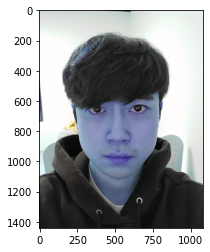

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/2.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

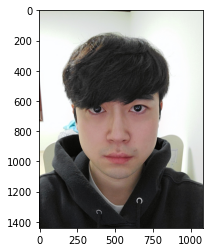

In [3]:
# 위 사진처럼 cv2 는 bgr로 사진이 출력되니 rgb로 다시 변환해야된다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 2 : 얼굴 검출 & 랜드마크 검출하기

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 얼굴의 bounding box 추출

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor를 이용해 변환
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(233, 542) (788, 1096)]]


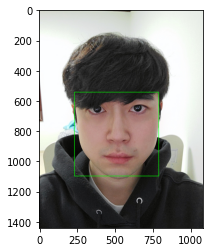

In [5]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
# landmark 모델 가져오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


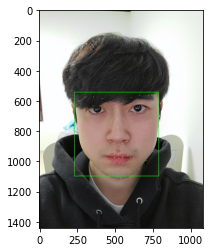

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show() # 랜드마크 이미지 출력

## Step 3 : 스티커 적용 위치 확인하기 

In [9]:
# 얼굴 위치 출력
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h)) # 스티커 크기

(519, 838)
(x,y) : (519,561)
(w,h) : (556,556)


In [10]:
# 고양이 수염 스티커 불러오기 및 크기 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path,1) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
print()


(556, 556, 3)



In [11]:
# 스티커 위치 조정 코양이 수염 스티커는 코에 붙이는 거기 때문에 x,y 그래도 출력 
refined_x = x // 2
refined_y = y


# 스티커가 사진 밖으로 나가서 음수값 출력됨을 방지
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (259,561)


## Step 4 : 스티커 적용하기

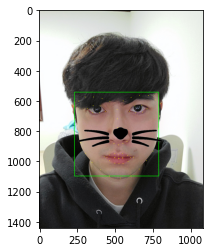

In [12]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5 : Boundary box and Landmark 제거 및 출력

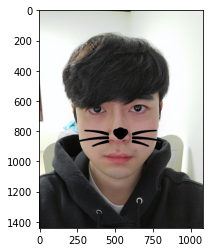

In [13]:
# boundary box 와 landmark 제거 후 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---

> 4) 응용 Project
-

## 다른 각도에서 촬영했을때


### Step 1 : 데이터 불러오기

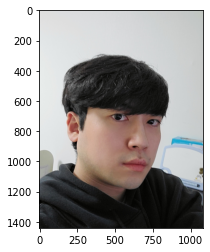

(1440, 1080, 3)


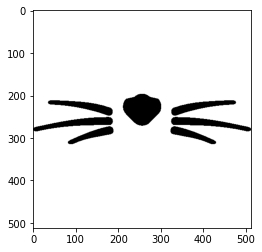

In [14]:
# 데이터 불러오기 / 사용할 모듈들은 위에서 불러왔기때문에 생략

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/a1.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR -> RGB로 변환
plt.imshow(img_rgb)
plt.show()
print (img_rgb.shape)

sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path,1) # 스티커 이미지를 불러옵니다
plt.imshow(img_sticker)
plt.show()

### Step 2 : 얼굴 검출 & 랜드마크 검출하기

In [15]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 얼굴의 bounding box 추출

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor를 이용해 변환
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(356, 542) (911, 1096)]]


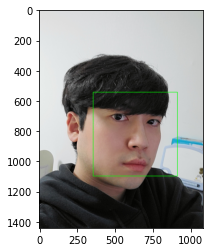

In [16]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [17]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [18]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


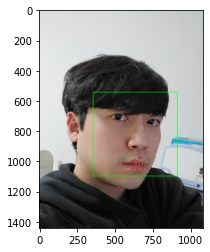

In [19]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show() # 랜드마크 이미지 출력

### Step 3 : 스티커 적용위치 확인하기

In [20]:
# 얼굴 위치 출력
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y)) # 코의 중심점
    print ('(w,h) : (%d,%d)'%(w,h)) # 스티커 크기

(696, 875)
(x,y) : (696,598)
(w,h) : (556,556)


In [21]:
# 고양이 수염 스티커 불러오기 및 크기 조정
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path,1) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
print()


(556, 556, 3)



In [22]:
# 스티커 위치 조정 코양이 수염 스티커는 코에 붙이는 거기 때문에 x,y 그래도 출력 
refined_x = (x  // 2) + ((landmark[14][0]-landmark[30][0]) + (landmark[30][0]-landmark[2][0]))//10
refined_y = y


# 스티커가 사진 밖으로 나가서 음수값 출력됨을 방지
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (402,598)


### Step 4 : 스티커 적용하기

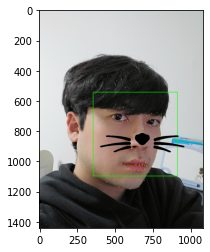

In [23]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step 5 : Boundary box & Landmark 제거 및 출력

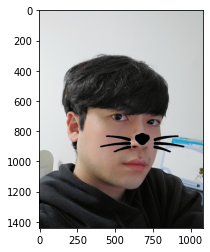

In [24]:
# boundary box 와 landmark 제거 후 출력
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---
> 5) 회고
-

## (1) 발생한 문제점들 
1. Lms에서 제공하는 스티커를 다운받아 이용했는데 수염부분은 투명해지고 나머지가 하애지는 현상으로 인해서 기존의 사진이 안보이게 되는 현상이 발생했습니다.
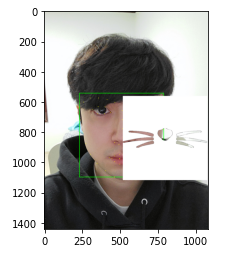  

위 문제 해결을 위해  np.where(img_sticker==1,sticker_area,img_sticker).astype(np.uint8) 에서 조건부분을
1을 함으로써 스티커가 컬러인 부분만 나오게 했는데 그럼에도 아직 하얀색 배경을 지워지지 않았다.
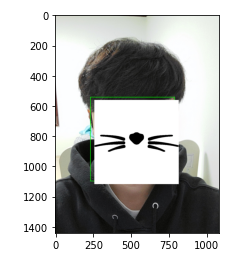

해결!
np.where(조건, True, False) 형태를 띄는건 알았는데,색의 범위를 0~255 범위로 가지고 조건을 주는건 생각을 못해서 어렵게 풀었었다.
저흰 Lms 조 고건호님께서 색의 범위 255로 설정 가능하다고 알려주셔서 풀 수 있었다.


2. 각도가 변경될때 스티커가 정중앙에 오지 않는 문제가 발생했습니다.  

처음 생각한 방법은 단순하게 refined_x = (x  // 2) + 50 에다가 수치를 대입해서 스티커를 붙였지만 이렇게 했을 경우에는 각도가 변할때마다 값을 찾기위해 시행착오를 해야되는 일이 생기기 때문에 다른 방법을 찾았습니다.  
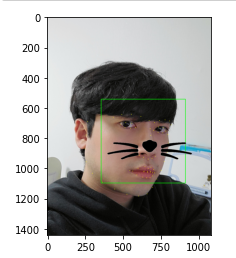
                                        [시행착오]  
![Landmark](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)



얼굴이 좌우로 돌아갈때 14와 30 사이의 거리 30과 2사이의 거리를 빼서 구하려고 생각을 했습니다.  
예를 들어 오른쪽으로 돌아갔을때 14와 30사이 거리는 커질테고 30와 2사이의 거리는 줄어들 것이기 때문에 그 차이만큼 더하는 식입니다.  
스티커 부착위치 = 30위치 + (14 - 30) - (30 - 2) 라고 생각하고 처음에는   

refined_x = (x  // 2) + ((landmark[14][0]-landmark[30][0]) + (landmark[30][0]-landmark[2][0]))  

로 만들었는데 볼과 코사이의 거리가 너무 커서 스티커를 붙일 수 없는 에러가 발생했습니다.  
그래서 그 차이를 줄이려고 1~10까지의 값을 통해서 나눴습니다.  
그 결과 생각보다 볼과 코사이의 랜드마크 점 거리가 길어서 10으로 나눴을 때 가장 이상적으로 스티커를 붙일 수 있었습니다.

---
## (2) 이번 노드를 진행하며

익숙하던 카메라 앱 기능들을 직접 해보니깐 어려우면서도 재밌는 노드였습니다.  
사실 시키는 대로 진행을 했기 때문에 얼굴 검출의 원리가 어떤건지 이미지 피라미드는 또 뭔지 하는 등의 의문점들이 많이 쌓였기 때문에  
앞으로 알아야 할게 많구나 하고 생각하게 된 노드였습니다.  

각도를 살짝 튼 것만으로도 생각해볼게 많았습니다.  
노드를 진행하면서 친구들과 같이 있는 사진들로도 스티커 부착이 가능할까? 생각하고 시험을 해봤는데  
생각보다 인식이 안되는 문제가 컸습니다. 세명이서 찍은 사진이어도 두명 까지밖에 인식이 안됐고 스티커를 붙이는데도 기존의 랜드마크의 위치를 통해 붙이는 방식으로는 한명한테만 붙기 때문에 어려움이 컸습니다.  

## (3) 궁금한점 미비점 그리고 보완할 점

+ 여러명이 있을 경우에 인식까지는 가능해도 스티커를 어떻게 붙일 것인지?  
+ 스티커를 가장 이상적으로 붙일 수 있는 계산 방법이 있을것인지? Ex) 얼굴의 각도가 바뀔 때, 거리가 멀어질때
+ 어두운 환경이나 너무 밝은 환경에서 해결 방법 -> gray scale로 뽑은 다음에 구했을 때도 안구해질때가 있었습니다.


> 참조
-

1) np.where 의 사용방법 https://m.blog.naver.com/bosongmoon/221791527433  
2) 얼굴 검출 코드 깃허브 https://github.com/opencv/opencv/tree/master/data/haarcascades  
3) 여러명 얼굴 탐지 참고 https://jinho-study.tistory.com/229?category=926937  
